
Training QRNN (steep quadratic, batch-scaled targets):
Epoch   1 | MSE = 0.130874
    flow      temp      conc  true_eff  pred_eff
9.541566 28.316954 60.000000  0.279944  0.232875
9.753514 20.280878 22.372952  0.734253  0.440508
3.366384 27.985441 52.622627  0.671104  0.207741
9.756826  2.838661 46.368385  0.210375  0.250644
4.929906  5.521353 10.147384  0.541943  0.379995 
... saved epoch_csv/epoch_001_predictions.csv

Epoch  20 | MSE = 0.055140
    flow      temp      conc  true_eff  pred_eff
9.541566 28.316954 60.000000  0.279944  0.529466
9.753514 20.280878 22.372952  0.734253  0.585934
3.366384 27.985441 52.622627  0.671104  0.546089
9.756826  2.838661 46.368385  0.210375  0.527982
4.929906  5.521353 10.147384  0.541943  0.476133 
... saved epoch_csv/epoch_020_predictions.csv

Epoch  40 | MSE = 0.045839
    flow      temp      conc  true_eff  pred_eff
9.541566 28.316954 60.000000  0.279944  0.545430
9.753514 20.280878 22.372952  0.734253  0.631277
3.366384 27.985441 52.622627  0.

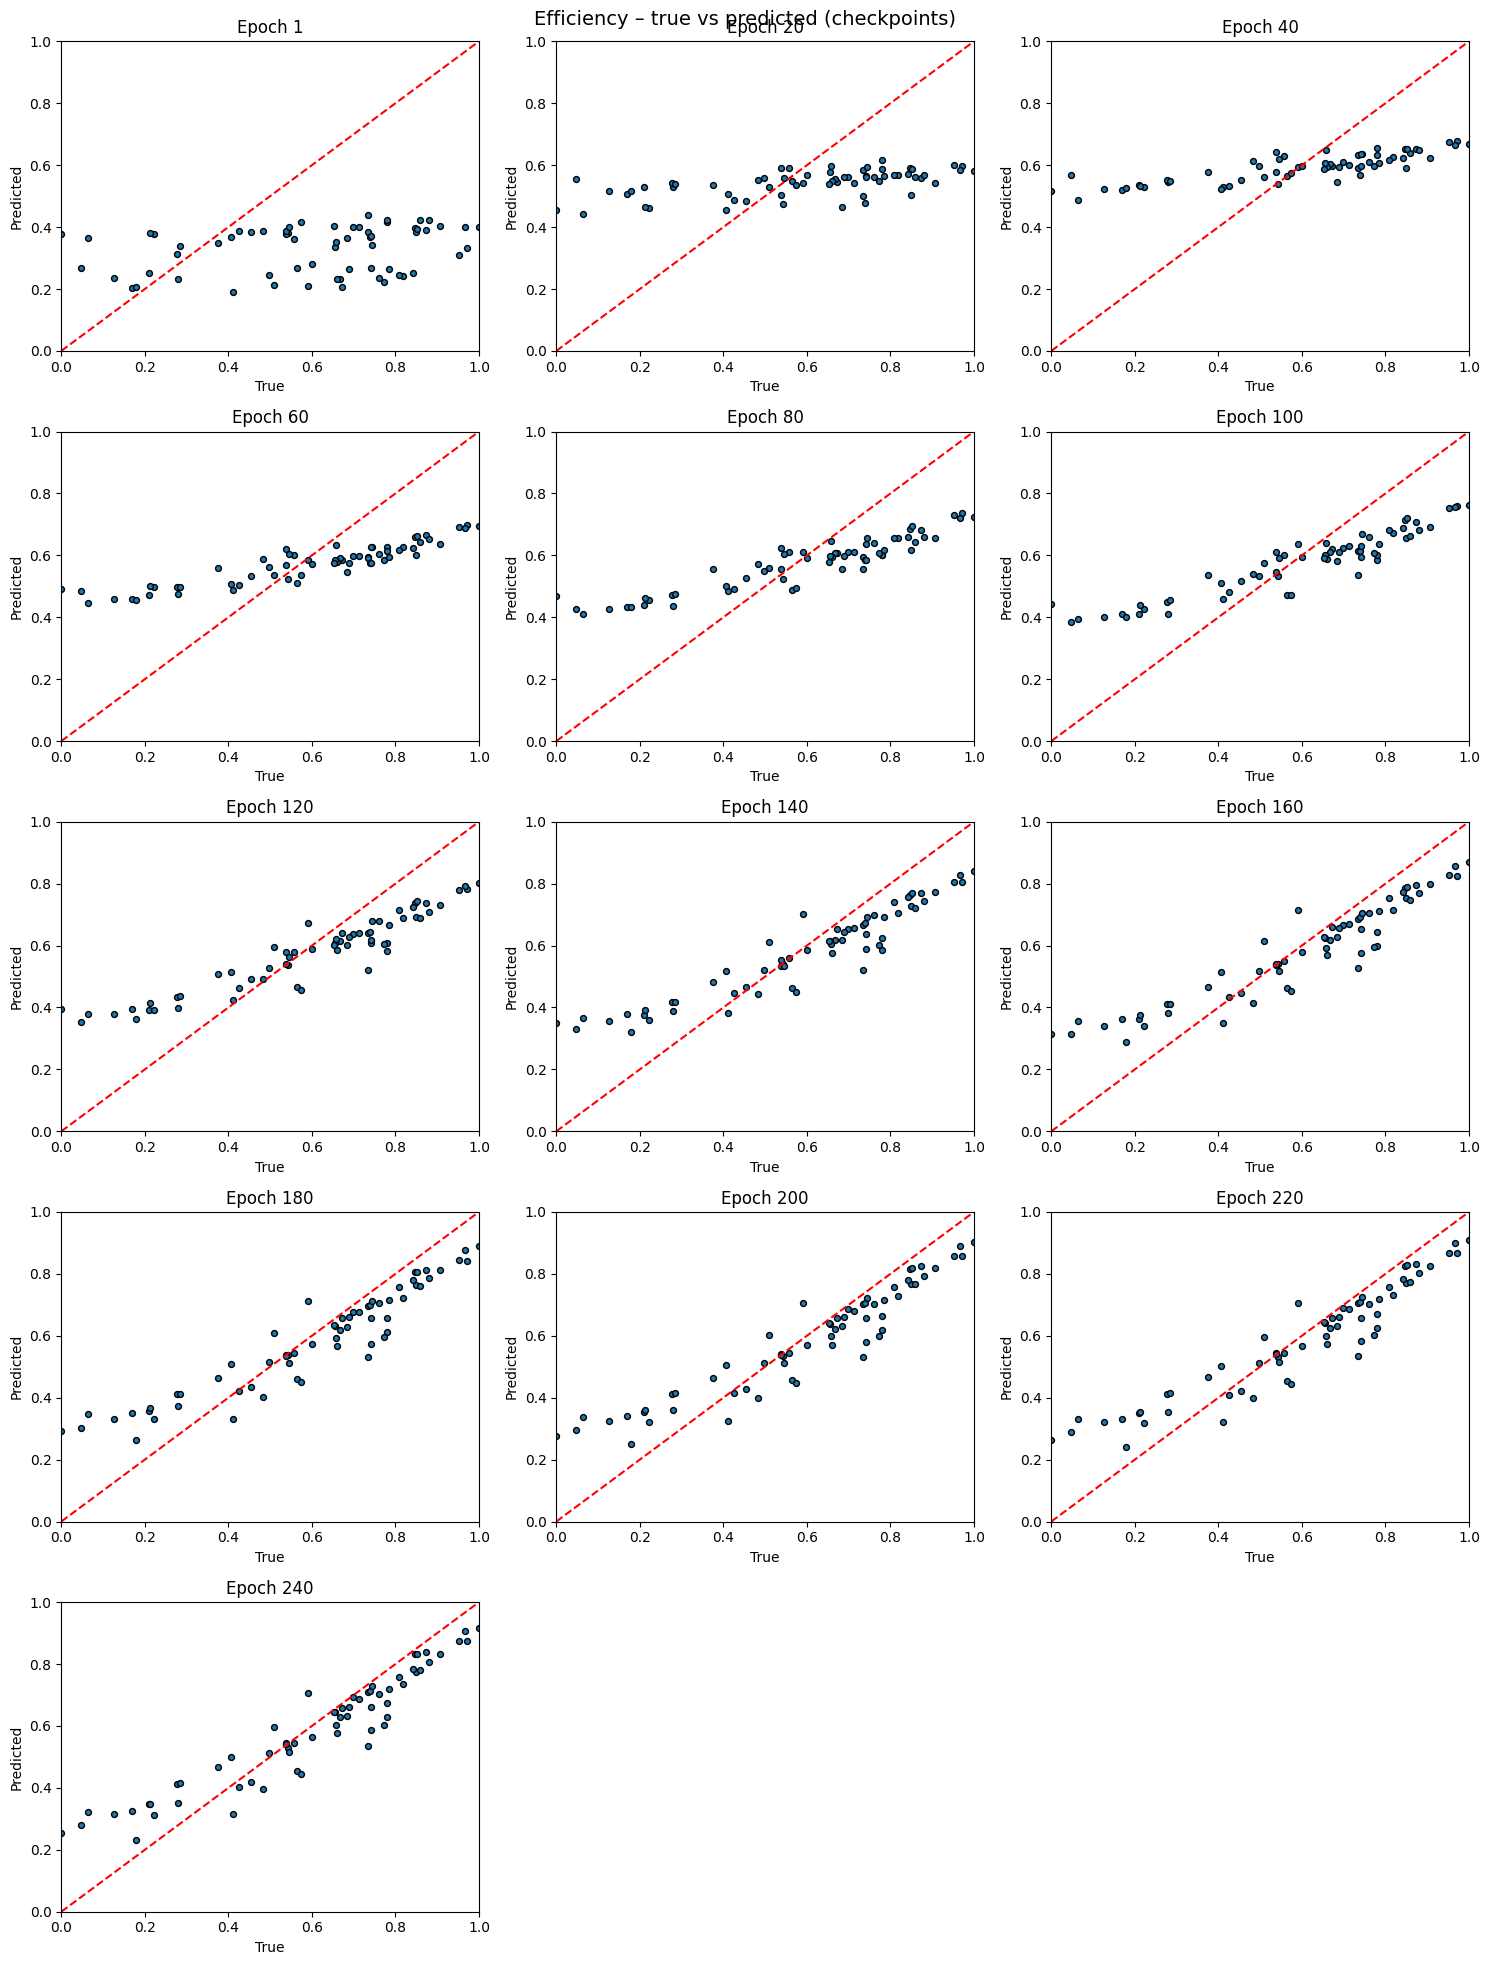

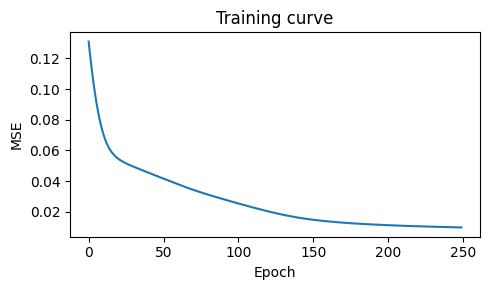

In [60]:
#!/usr/bin/env python
"""
quantum_qrnn_quadratic_wide_range.py   (all fixes applied)
----------------------------------------------------------

• Generates full-spectrum physics data
      flow 0–10 m³/s, temp 0–40 °C, conc 1–60 PSU

• Encodes to 7-qubit product states after normalising each feature to [0,1].

• Uses a **steep quadratic bowl** so raw efficiencies span roughly −0.3 … 1,
  then rescales **per-batch** to the target interval [0,1].

• Trains a QRNN; every 20 epochs:
      – dumps CSV with flow, temp, conc, true_eff, pred_eff for **all** samples
      – prints first five rows.

• Shows scatter-grid of checkpoints and the loss curve.

Fixed:
  * inner `torch.stack` inside `build_dataset`
  * `.detach().cpu().numpy()` when building the pandas DataFrame
"""

# ── imports ──────────────────────────────────────────────────────────────────
import torch, math, functools, torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd, os, pathlib
import pennylane as qml
from pennylane.qnn import TorchLayer

# ── hyper-params ─────────────────────────────────────────────────────────────
batch_size, seq_len = 64, 12
n_inputs, n_hidden  = 3, 4
n_qubits            = n_inputs + n_hidden
epochs, lr          = 250, 5e-3
plot_every          = 20
out_dir             = pathlib.Path("epoch_csv")
out_dir.mkdir(exist_ok=True)

# ── 1) physics generator (normalised) ────────────────────────────────────────
def build_phys_norm(T=seq_len, B=batch_size):
    rng = torch.Generator().manual_seed(42)
    flow = torch.rand(B, generator=rng) * 10
    temp = torch.rand(B, generator=rng) * 40
    conc = torch.rand(B, generator=rng) * 59 + 1
    phys = torch.zeros(T, B, 3)
    for t in range(T):
        if t:
            flow = (flow + torch.randn(B)*0.4).clamp(0,10)
            temp = (temp + torch.randn(B)*1.2).clamp(0,40)
            conc = (conc + torch.randn(B)*2.0).clamp(1,60)
        phys[t,:,0] = flow      / 10.0
        phys[t,:,1] = temp      / 40.0
        phys[t,:,2] = (conc-1)  / 59.0
    return phys                                            # (T,B,3) ∈[0,1]

# ── 2) encoder ───────────────────────────────────────────────────────────────
def single_qubit_state(z):
    θ = z * math.pi
    return torch.stack([torch.cos(θ/2), torch.sin(θ/2)])

def encode_to_amp(zf, zt, zc):
    vec = functools.reduce(
        torch.kron,
        [single_qubit_state(z) for z in (zf,zt,zc)] +
        [torch.tensor([1.,0.])] * n_hidden
    )
    return vec / vec.norm()

# ── 3) steep quadratic (raw) ─────────────────────────────────────────────────
def raw_efficiency(zf, zt, zc):
    f = zf * 10
    t = zt * 40
    c = zc * 59 + 1
    return (
        1
        - 0.60 * ((f - 5)  / 10 )**2
        - 0.30 * ((t - 20) / 20 )**2
        - 0.20 * ((c - 30) / 29.5)**2
    )  # may drop below 0

# ── 4) dataset builder (rescale targets to [0,1]) ───────────────────────────
def build_dataset():
    phys = build_phys_norm()
    X_amp = torch.stack([
        torch.stack([encode_to_amp(*phys[t,b]) for b in range(batch_size)])
        for t in range(seq_len)
    ])                                                   # (T,B,128)

    last = phys[-1]
    y_raw = raw_efficiency(last[:,0], last[:,1], last[:,2])
    y_min, y_max = y_raw.min(), y_raw.max()
    Y = ((y_raw - y_min) / (y_max - y_min)).unsqueeze(1) # batch-scaled [0,1]

    return X_amp, Y, phys

# ── 5) QRNN definition (TorchLayer requires arg name “inputs”) ──────────────
dev_rec = qml.device("default.qubit", wires=n_qubits)
dev_out = qml.device("default.qubit", wires=n_hidden)

@qml.qnode(dev_rec, interface="torch")
def qrnn_cell(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=n_inputs+j)) for j in range(n_hidden)]

qrnn_layer = TorchLayer(qrnn_cell, weight_shapes={"weights": (2, n_qubits, 3)})
qrnn_layer.batch_execute = False

@qml.qnode(dev_out, interface="torch")
def qnn_readout(inputs, weights):
    for j in range(n_hidden):
        qml.RY(inputs[j], wires=j)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_hidden))
    return qml.expval(qml.PauliZ(wires=0))

qnn_out_layer = TorchLayer(qnn_readout,
                           weight_shapes={"weights": (3, n_hidden, 3)})
qnn_out_layer.batch_execute = False

class QRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qrnn = qrnn_layer
        self.qout = qnn_out_layer
    def forward(self, x_seq):
        B = x_seq.shape[1]
        h = torch.zeros(B, n_hidden)
        for t in range(x_seq.shape[0]):
            h = torch.stack([self.qrnn(x_seq[t,b]) for b in range(B)])
        return torch.stack([self.qout(h[b]) for b in range(B)]).unsqueeze(1)

# ── 6) training loop with CSV dumps ─────────────────────────────────────────
X_amp, Y_true, phys = build_dataset()
model = QRNN()
opt   = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
losses, snapshots = [], {}

print("\nTraining QRNN (steep quadratic, batch-scaled targets):")
for ep in range(1, epochs + 1):
    opt.zero_grad()
    Y_pred = model(X_amp)
    loss   = loss_fn(Y_pred, Y_true)
    loss.backward(); opt.step()
    losses.append(loss.item())

    if ep % plot_every == 0 or ep == 1:
        snapshots[ep] = (Y_true.detach().clone(), Y_pred.detach().clone())
        print(f"Epoch {ep:3d} | MSE = {loss.item():.6f}")

        last = phys[-1]
        df = pd.DataFrame({
            "flow": (last[:,0]*10).cpu().numpy(),
            "temp": (last[:,1]*40).cpu().numpy(),
            "conc": (last[:,2]*59+1).cpu().numpy(),
            "true_eff": Y_true.squeeze().cpu().numpy(),
            "pred_eff": Y_pred.squeeze().detach().cpu().numpy()  # detach fix
        })
        csv_path = out_dir / f"epoch_{ep:03d}_predictions.csv"
        df.to_csv(csv_path, index=False)
        print(df.head(5).to_string(index=False),
              f"\n... saved {csv_path}\n")

# ── 7) scatter grid of checkpoints ─────────────────────────────────────────
cols = 3; rows = math.ceil(len(snapshots)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
for ax, (ep, (yt, yp)) in zip(axes.flat, snapshots.items()):
    ax.scatter(yt.squeeze(), yp.squeeze(), edgecolors="k", s=18)
    ax.plot([0,1],[0,1],"r--")
    ax.set_title(f"Epoch {ep}")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_xlabel("True"); ax.set_ylabel("Predicted")
for ax in axes.flat[len(snapshots):]:
    ax.axis("off")
fig.suptitle("Efficiency – true vs predicted (checkpoints)", fontsize=14)
plt.tight_layout(); plt.show()

# ── 8) loss curve ──────────────────────────────────────────────────────────
plt.figure(figsize=(5,3))
plt.plot(losses)
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.title("Training curve"); plt.tight_layout(); plt.show()